# Vegetation Index using Sentinel-1 and Sentinel-2 

* **Products used:** 
[s1_rtc](),
[s2_l2a](https://explorer.digitalearth.africa/s2_l2a)


## Background
Phenology is the study of plant and animal life cycles in the context of the seasons.
It can be useful in understanding the life cycle trends of crops and how the growing seasons are affected by changes in climate.
For more information, see the [USGS page on deriving phenology from NDVI time-series.](https://www.usgs.gov/land-resources/eros/phenology/science/deriving-phenological-metrics-ndvi?qt-science_center_objects=0#qt-science_center_objects)

## Description

This notebook  gives an example of using Sentinel-1 analysis ready data (ARD) radar backscatter (Gamma nought) for exploring annual vegetation dynamics by using **Radar Vegetation Index(RVI)**. RVI is a function of incidence angle since the path length through the vegetation canopy will increase as the incidence angle increases; however, the current analysis focuses on a single incidence angle. The RVI has been proposed as a method for monitoring the level of vegetation growth, particularly when time series data are available.
RVI generally ranges between 0 and 1 and is a measure of the randomness of the scattering. RVI is near zero for a smooth bare surface and increases as a crop grows (up to a point in the growth cycle).

This notebook also demonstrates how to calculate vegetation phenology statistics using the DE Africa function [xr_phenology](../Scripts/deafrica_temporal_statistics.py).  To detect changes in plant life for Sentinel-2, the script uses the **Enhanced Vegetation Index (EVI)** and **Normalized Difference Vegetation Index(NDVI)** which are common proxy for vegetation growth and health.

Sentinel-1 data are indexed as product "S1_rtc" for radar backscatter.The dual-pol Radar Vegetation Index (RVI) from Sentinel-1 will be compared  with Sentinel-2 NDVI for multi-temporal trends due to their relationship with vegetaton biomass. Monthly means for the RVI will be generated and saved as a GeoTiff. 

The outputs of this notebook can be used to assess spatio-temporal differences in the growing seasons of agriculture fields or native vegetation.

This notebook demonstrates the following steps:

1. Load Sentinel-1 radar backscatter and cloud-masked Sentinel-2 data for an area of interest.
2. Apply speckle filtering 
3. Calculate Vegetation Indices EVI and RVI
4. Compare RVI and RVI timeseries
***

In [1]:
#load all the packages/libraries 
%matplotlib inline

import os
import datacube
import numpy as np
import pandas as pd
import xarray as xr
import datetime as dt
import matplotlib.pyplot as plt

import deafrica_tools.temporal as ts
from deafrica_tools.datahandling import load_ard
from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.plotting import display_map, rgb


from datacube.utils.aws import configure_s3_access
from deafrica_tools.dask import create_local_dask_cluster
from deafrica_tools.classification import HiddenPrints
from scipy.ndimage.filters import uniform_filter
from scipy.ndimage.measurements import variance
configure_s3_access(aws_unsigned=True, cloud_defaults=True)

ModuleNotFoundError: No module named 'deafrica_tools'

## 1. demo over an area with clear S2 series and S1 to show how S1 can also reliably track crop growth. 

In [ ]:
#find an area with good S2 series first 

#Check the coverage in that area for S1


## 2. example over a cloudy area where S2 has gaps.

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Load key Python packages and supporting functions for the analysis.

In [2]:
%matplotlib inline

import os
import datacube
import numpy as np
import pandas as pd
import xarray as xr
import datetime as dt
import matplotlib.pyplot as plt

import deafrica_tools.temporal as ts
from deafrica_tools.datahandling import load_ard
from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.plotting import display_map, rgb


from datacube.utils.aws import configure_s3_access
from deafrica_tools.dask import create_local_dask_cluster
from deafrica_tools.classification import HiddenPrints
from scipy.ndimage.filters import uniform_filter
from scipy.ndimage.measurements import variance
configure_s3_access(aws_unsigned=True, cloud_defaults=True)

## Set up a Dask cluster

Dask can be used to better manage memory use down and conduct the analysis in parallel. For an introduction to using Dask with Digital Earth Africa, see the Dask notebook.

In [3]:
create_local_dask_cluster(spare_mem='1Gb')

/env/lib/python3.6/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36287 instead
  http_address["port"], self.http_server.port


Client Scheduler: tcp://127.0.0.1:37787 Dashboard: /user/neginm/proxy/36287/status,Cluster Workers: 1 Cores: 15 Memory: 106.37 GB


### Analysis parameters

The following cell sets important parameters for the analysis:

* `veg_proxy`: Band index to use as a proxy for vegetation health e.g. `'NDVI'` or `'EVI'`
* `product`: The satellite product to load. Either Sentinel-2: `'s2_l2a'`, or Sentinel-1: `'s1_rtc'`
* `lat`: The central latitude to analyse (e.g. `-10.6996`).
* `lon`: The central longitude to analyse (e.g. `35.2708`).
* `buffer`: The number of square degrees to load around the central latitude and longitude.
For reasonable loading times, set this as `0.1` or lower.
* `time_range`: The year range to analyse (e.g. `('2017-01-01', '2019-12-30')`).
* `min_gooddata`: the fraction of good data (not cloudy) a scene must have before it is returned as a dataset 
* `resolution`: The pixel resolution, in metres, of the returned dataset
* `dask_chunks`: The size, in number of pixel, for the dask chunks on each dimension.

In [4]:
#Set the vegetation proxy to use 
veg_proxy1 = 'NDVI'
veg_proxy2 = 'EVI'
veg_proxy3 = 'MNDWI'
#Set the product to use 
productA = 's2_l2a'
productB = 's1_rtc'
#set the location 
#Aviv Coffee Farm, Tanzania
lat = -10.6979 
lon = 35.2635
lon_buffer = 0.003
lat_buffer = 0.003
# Combine central lat,lon with buffer to get area of interest
lat_range = (lat-lat_buffer, lat+lat_buffer)
lon_range = (lon-lon_buffer, lon+lon_buffer)
# Set the range of dates for the analysis
time_range = ('2020-01-01','2020-12-31')
min_gooddata = 0.15
resolution = (-20,20)
dask_chunks = {'x':750, 'y':750}


### Connect to the datacube

Connect to the datacube so we can access DE Africa data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [5]:
dc = datacube.Datacube(app='Vegetation_phenology_S1')

In [6]:
dc.list_products().loc[dc.list_products()['description'].str.contains('radar')]

,name,description,lat,creation_time,format,instrument,dataset_maturity,platform,product_family,product_type,label,region_code,lon,time,crs,resolution,tile_size,spatial_dimensions
id,,,,,,,,,,,,,,,,,,
3,s1_rtc,Sentinel 1 Gamma0 normalised radar backscatter,None,None,None,None,NaN,None,NaN,NaN,None,NaN,None,None,NaN,NaN,NaN,NaN



## Load Sentinel-1 radar backscatter data and cloud-masked Sentinel-2 

The first step is to load Sentinel-1 radar backscatter and Sentinel-2 cloud-masked data for the specified area of interest and time range. 
`dc.load()` function is used to return a time series of satellite images. The returned xarray.Dataset dataset will contain analysis ready images over coffee field in part of Tanzania.

In [7]:
# Create a reusable query for Sentinel-2
query_S2 = {
    'x': lon_range,
    'y': lat_range,
    'time': time_range,
    'measurements': ['red','blue','nir','green','swir_1','SCL'],
    'resolution': resolution,
    'output_crs': 'epsg:6933',
    'group_by':'solar_day'
}

# # Load available data from Sentinel-2
ds_S2 = dc.load(product=productA,
             **query_S2)

print(ds_S2)

<xarray.Dataset>
Dimensions:      (time: 72, x: 30, y: 38)
Coordinates:
  * time         (time) datetime64[ns] 2020-01-04T08:02:50 ... 2020-12-29T08:...
  * y            (y) float64 -1.357e+06 -1.357e+06 ... -1.357e+06 -1.357e+06
  * x            (x) float64 3.402e+06 3.402e+06 ... 3.403e+06 3.403e+06
    spatial_ref  int32 6933
Data variables:
    red          (time, y, x) uint16 1296 1188 1220 1150 ... 5024 5028 4848 4808
    blue         (time, y, x) uint16 1050 1124 1064 1070 ... 5284 5176 4928 4728
    nir          (time, y, x) uint16 3492 3892 3748 3820 ... 5592 5524 5380 5304
    green        (time, y, x) uint16 1306 1356 1334 1310 ... 5252 5156 4920 4892
    swir_1       (time, y, x) uint16 2313 2363 2341 2277 ... 5037 5065 5046 4995
    SCL          (time, y, x) uint8 10 10 10 10 10 10 10 10 ... 9 9 9 9 9 9 9 9
Attributes:
    crs:           epsg:6933
    grid_mapping:  spatial_ref


In [7]:
# Create a reusable query for Sentinel-1
query_S1 = {
    'x': lon_range,
    'y': lat_range,
    'time': time_range,
    'measurements': ['vv', 'vh', 'mask','angle'],
    'resolution': resolution,
    'output_crs': 'epsg:6933',
    'group_by':'solar_day'
}

# # Load available data from Sentinel-1
ds_S1 = dc.load(product=productB,
             **query_S1)

#creation of a new band (VH/VV=vhvv) for RGB display 
ds_S1['vhvv'] = ds_S1.vh.where(ds_S1.mask==1) / ds_S1.vv.where(ds_S1.mask==1)
print(ds_S1)

<xarray.Dataset>
Dimensions:      (time: 56, x: 30, y: 38)
Coordinates:
  * time         (time) datetime64[ns] 2020-01-07T03:14:13.993855 ... 2020-12...
  * y            (y) float64 -1.357e+06 -1.357e+06 ... -1.357e+06 -1.357e+06
  * x            (x) float64 3.402e+06 3.402e+06 ... 3.403e+06 3.403e+06
    spatial_ref  int32 6933
Data variables:
    vv           (time, y, x) float32 0.20611408 0.35285792 ... 0.24822614
    vh           (time, y, x) float32 0.040316228 0.040432718 ... 0.020643808
    mask         (time, y, x) uint8 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
    angle        (time, y, x) uint8 42 42 44 44 43 42 41 ... 34 34 34 34 34 33
    vhvv         (time, y, x) float32 0.19560152 0.1145864 ... 0.083165325
Attributes:
    crs:           epsg:6933
    grid_mapping:  spatial_ref


In [8]:
#identify and remove the scenes that are mostly null values 
No_px=len(ds_S1.x)*len(ds_S1.y)
valid=ds_S1.where(ds_S1.vv!=0).where(ds_S1.vh!=0).count(dim=('x','y'))
good=(valid.vh/No_px)>0.5
S1 = ds_S1.sel(time=good)

In [ ]:
S1

## View the selected location
The next cell will display the selected area on an interactive map.
Feel free to zoom in and out to get a better understanding of the area you'll be analysing.
Clicking on any point of the map will reveal the latitude and longitude coordinates of that point.

In [9]:
display_map(x=lon_range, y=lat_range)

**Once the load is complete**, we can plot some of the images as as a true-colour composite image using the `rgb` function.

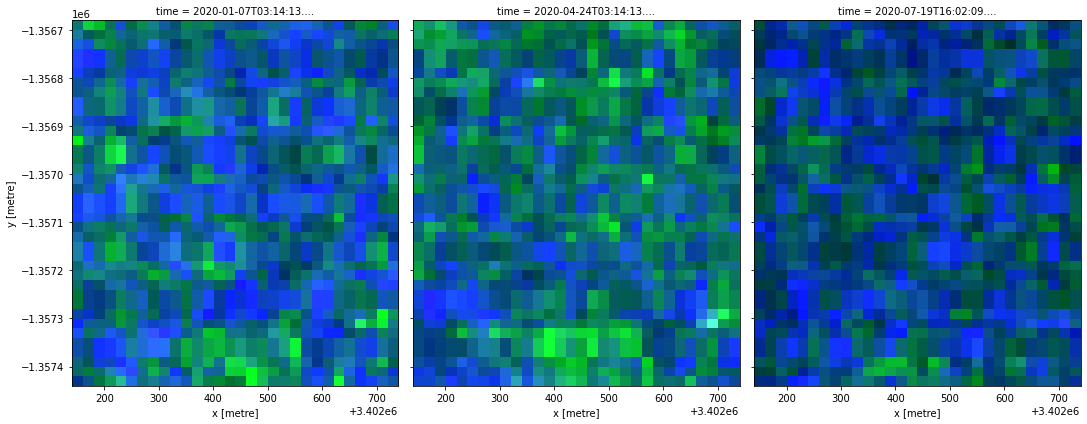

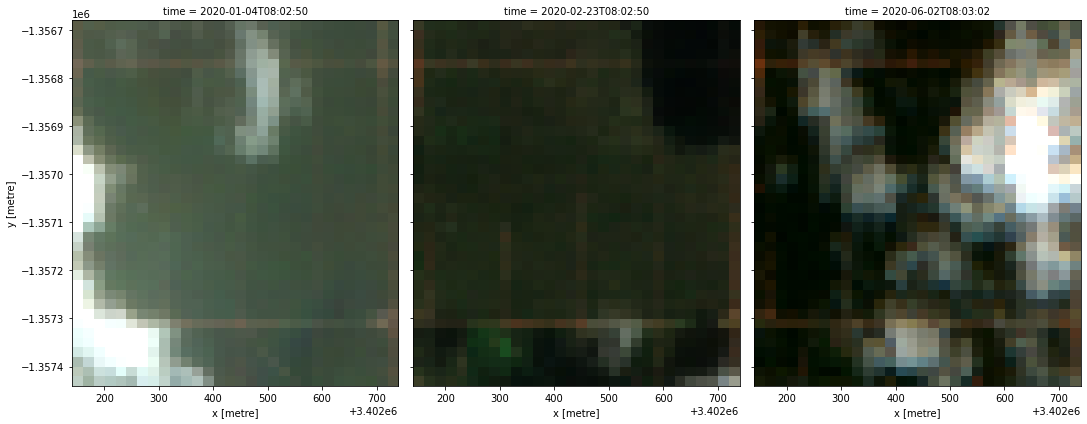

In [10]:
# Generate RGB plots at each timestep
rgb(S1, bands=['vh','vv','vhvv'], index=[0,15,30])
rgb(ds_S2, index=[0,10,30], col_wrap=3, size=6)

## Apply speckle filtering - not needed 

The distortion you're seeing in Sentinel-1 imagery is a type of noise known as speckle, which gives the images a grainy appearence.
If we want to be able to easily decide what landcover type each particular pixel belongs to, we need to reduce the chance of misinterpreting  due to the noise.

Speckle can be removed through filtering.
If interested, you can find a technical introduction to speckle filtering [here](https://earth.esa.int/documents/653194/656796/Speckle_Filtering.pdf).
For now, it is enough to know that we can filter the data using the Python function defined in the next cell:

In [11]:
def lee_filter(da, size):
    img = da.values
    img_mean = uniform_filter(img, (size, size))
    img_sqr_mean = uniform_filter(img**2, (size, size))
    img_variance = img_sqr_mean - img_mean**2

    overall_variance = variance(img)

    img_weights = img_variance / (img_variance + overall_variance)
    img_output = img_mean + img_weights * (img - img_mean)
    return img_output

Now that we've defined the filter, we can run it on the VV and VH data. You might have noticed that the function takes a size argument. This will change how blurred the image becomes after smoothing. We've picked a default value for this analysis, but you can experiement with this if you're interested.

In [12]:
# Set any null values to 0 before applying the filter to prevent issues
S1_filled = S1.where(~S1.isnull(), 0)

In [13]:
# Create new bands in dataset corresponding to filtered VV and VH data
filtered_vv= S1_filled.vv.groupby("time").apply(lee_filter, size=7)
filtered_vh= S1_filled.vh.groupby("time").apply(lee_filter, size=7)

In [14]:
#create smoothed dataset and assign attributes 
nodata_mask = S1.isnull().to_array().any(axis=0)
smoothed = filtered_vv.to_dataset(name='vv')
smoothed['vh'] = filtered_vh
smoothed = smoothed.where(~nodata_mask)
smoothed.assign_attrs(S1.attrs);

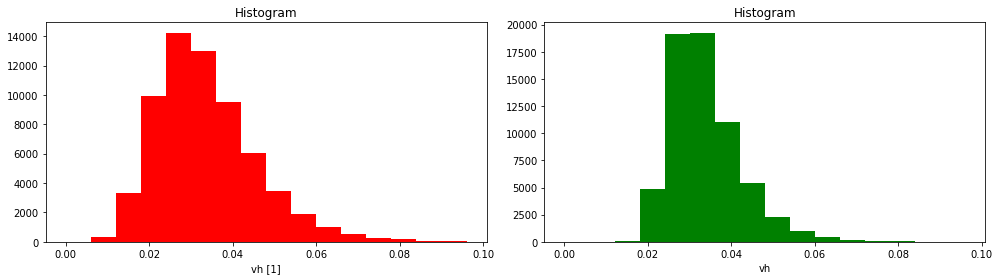

In [15]:
#plotting each polorisation bands following converting to dB values 
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
S1.vh.where(S1.mask==1).plot.hist(ax=ax[0],bins=np.arange(0,0.1,0.006), facecolor='red')
smoothed.vh.plot.hist(ax=ax[1],bins=np.arange(0,0.1,0.006), facecolor='green')
plt.tight_layout()

## Compute band indices

This study measures the presence of vegetation through the `normalised difference vegetation index (NDVI)` and the `Radar Vegetation Index(RVI)`.
The index for optical dataset i.e. Sentinel-2 is dictated by the `veg_proxy` parameter that was set in the "Analysis parameters" section.

The normalised difference vegetation index (NDVI) requires the `red` and `nir` (near-infra red) bands. 
The formula is

$$
\begin{aligned}
\text{NDVI} & = \frac{(\text{NIR} - \text{Red})}{(\text{NIR} + \text{Red})} \\
\end{aligned}
$$

The Radar Vegetation Index requires the `VH` and `VV` polarisation bands.
The formula is

$$
\begin{aligned}
\text{RVI} & = \frac{4 \times \text{VH}}{(\text{VV} + \text{VH})} \\
\end{aligned}
$$

The normalised difference vegetation index is available through the [calculate_indices](../Frequently_used_code/Calculating_band_indices.ipynb) function, imported from [deafrica_bandindices.py](../Scripts/deafrica_bandindices.py).
Here, we use `collection='s2'` since we're working with Sentinel-2 data.

In [16]:
# Calculate the chosen vegetation proxy index and add it to the loaded data set
ds_S2 = calculate_indices(ds_S2, index=[veg_proxy1, 'NDVI'], collection='s2')
ds_S2 = calculate_indices(ds_S2, index=[veg_proxy2,'EVI'], collection='s2')
ds_S2 = calculate_indices(ds_S2, index=[veg_proxy3,'MNDWI'], collection='s2')
#drop bands that are no longer needed (save memory)
ds_S2 = ds_S2.drop(['red','green','nir','blue','swir_1','SCL'])
#convert to float 32 to conserve memory
ds_S2=ds_S2.astype(np.float32)

The vegetation proxy index should now appear as a data variable, along with the loaded measurements, in the `ds` object.

In [17]:
# Calculate the Radar Vegetation Index and add it to the smoothed loaded S1 dataset 
smoothed['RVI'] = 4 *smoothed.vh/(smoothed.vv + smoothed.vh)

## Plot the vegetation index over time

To get an idea of how the vegetation health changes throughout the year(s), we can plot a zonal time series over the region of interest. First we will do a simple plot of the zonal mean of the data.  

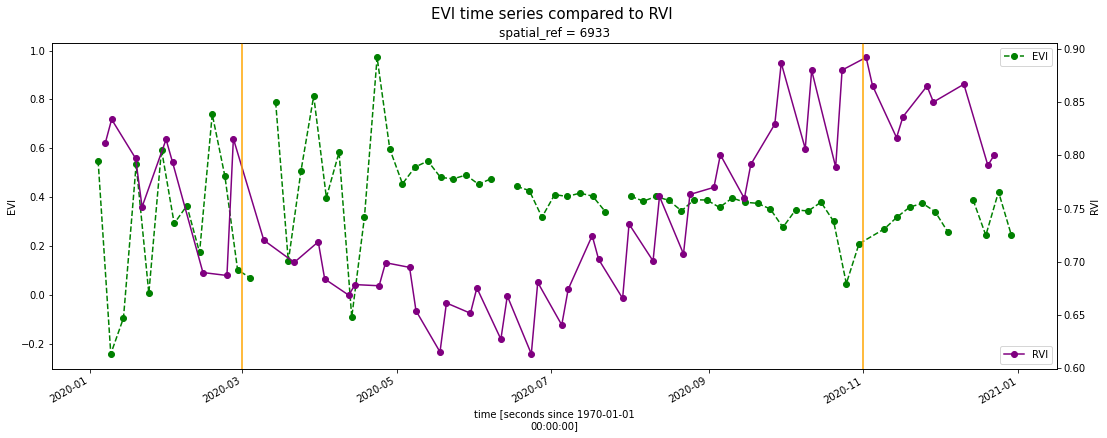

In [18]:
ndvi = ds_S2.NDVI.mean(['x', 'y'])
evi = ds_S2.EVI.mean(['x','y'])
rvi = smoothed.RVI.mean(['x', 'y'])

fig, ax = plt.subplots(figsize=(18, 6))

evi.plot.line('b-o', ax=ax, color='green', label='EVI', linestyle = 'dashed');
ax.set_title('EVI time series compared to RVI \n', fontsize="15", color="black")

ax2 = ax.twinx()
rvi.plot.line('b-o', ax=ax2, color='purple', label='RVI');

# ax3 = ax2.twinx()
# ndvi.plot.line('b-o',ax=ax3, color='green',label='NDVI' linestyle='dotted')

xpoints = ['2020-03', '2020-11']

for p in xpoints:
    plt.axvline(p, color='orange')

leg1 = ax.legend(loc='upper right',frameon=True)
leg2 = ax2.legend(loc='lower right',frameon=True)
# leg3 = ax3.legend(loc='lower left',frameon=True)

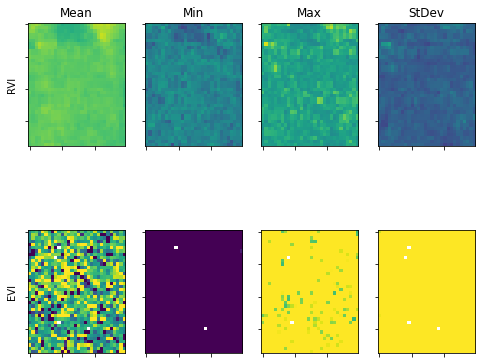

In [19]:
#Generate statistics on both RVI and EVI
RVI_mean = np.flip(smoothed.RVI.mean(dim='time'))
RVI_min = np.flip(smoothed.RVI.min(dim='time'))
RVI_max = np.flip(smoothed.RVI.max(dim='time'))
RVI_std = np.flip(smoothed.RVI.std(dim='time'))
EVI_mean = np.flip(ds_S2.EVI.mean(dim='time'))
EVI_min = np.flip(ds_S2.EVI.min(dim='time'))
EVI_max = np.flip(ds_S2.EVI.max(dim='time'))
EVI_std = np.flip(ds_S2.EVI.std(dim='time'))

fix, ax = plt.subplots(2,4, figsize=(8,7))
ax[0,0].imshow(RVI_mean, clim=(0,1.0))
ax[0,0].set_title('Mean')
ax[0,0].set_ylabel('RVI')
ax[0,0].set_xticklabels([])
ax[0,0].set_yticklabels([])
ax[0,1].imshow(RVI_min, clim=(0,1.0))
ax[0,1].set_title('Min')
ax[0,1].set_xticklabels([])
ax[0,1].set_yticklabels([])
ax[0,2].imshow(RVI_max, clim=(0,2.0))
ax[0,2].set_title('Max')
ax[0,2].set_xticklabels([])
ax[0,2].set_yticklabels([])
ax[0,3].imshow(RVI_std, clim=(0,0.5))
ax[0,3].set_title('StDev')
ax[0,3].set_xticklabels([])
ax[0,3].set_yticklabels([])
ax[1,0].imshow(EVI_mean, clim=(0.1,0.5))
ax[1,0].set_ylabel('EVI')
ax[1,0].set_xticklabels([])
ax[1,0].set_yticklabels([])
ax[1,1].imshow(EVI_min, clim=(0,0.05))
ax[1,1].set_xticklabels([])
ax[1,1].set_yticklabels([])
ax[1,2].imshow(EVI_max, clim=(0,1.0))
ax[1,2].set_xticklabels([])
ax[1,2].set_yticklabels([])
ax[1,3].imshow(EVI_std, clim=(0,0.2))
ax[1,3].set_xticklabels([])
ax[1,3].set_yticklabels([]);

## Conclusions

In the example above, we can observe differences in the rates of growth, and in the both EVI and RVI values at different times of the season, which may be attributable to differences in soil quality, watering intensity, or other farming practices. 

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:** 

In [20]:
print(datacube.__version__)

1.8.4.dev63+g6ee0462c


**Last Tested:**

In [21]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2021-05-10'